# **1. Introduction**

**Project:** SC1003 Mini Project (Division of Students into Team)

**Tutorial Group:** FCS4 (Team 5)

**Team Member:**
1. Tarun Ilangovan
2. Tyrone Tiang Jin Shen
3. Wayne Chua Eng Kiat (Cai RongJie)
4. Yong Chee Seng
5. Zhang Jun Zhe

# **2. Problem Statement**

Analyze the student list (records.csv) and then design and develop an algorithm that is capable of forming teams of 5 based on 3 criteria:

1. **School Affiliation:** No team should have a majority of students from the same school.
2. **Gender**: No team should have a majority of students from the same gender.
3. **Current CGPA**: Teams should not consist
predominantly of students with very high or very low CGPAs.

### **2.1 Analysis of Problem:**
1. **School Affiliation:** Most teams should consist of as many schools as possible.
2. **Gender**: Most teams should have a ratio of male to female as close to 1:1 as possible.
3. **Current CGPA**: The average CGPA of each team should be close to the overall average CGPA of the tutorial group, with low variance between teams.

### **2.2 Decomposition of Problem:**
1. **Read the Input:** Read the `records.csv` file to gather student data.
2. **Process the input:** Convert input into a suitable data structure, sort it, and  extract key information needed for team division.
3. **Basic division of teams:** Implement logic to divide students based on school, gender, and CGPA.
4. **Refine division of teams:** Apply a heuristic approach to improve the balance of teams.
5. **Analyse the division of teams:** Evaluate the teams for school diversity, gender balance, and average CGPA variance.
6. **Plot the analysis:** Plot analysis into a suitable graph for visualization.
6. **Output:** Write the final team assignments to a CSV file in the correct format.

### **2.3 Additional Requirement:**
1. **Customizable Team Sizes**: The program should be able to work on variable team sizes.
2. **Basic UI for Interactivity**: The user should be able to interact with the program, adjust parameters (e.g., team size), and view results.

### **2.4 Overview of Entire Procedure:**
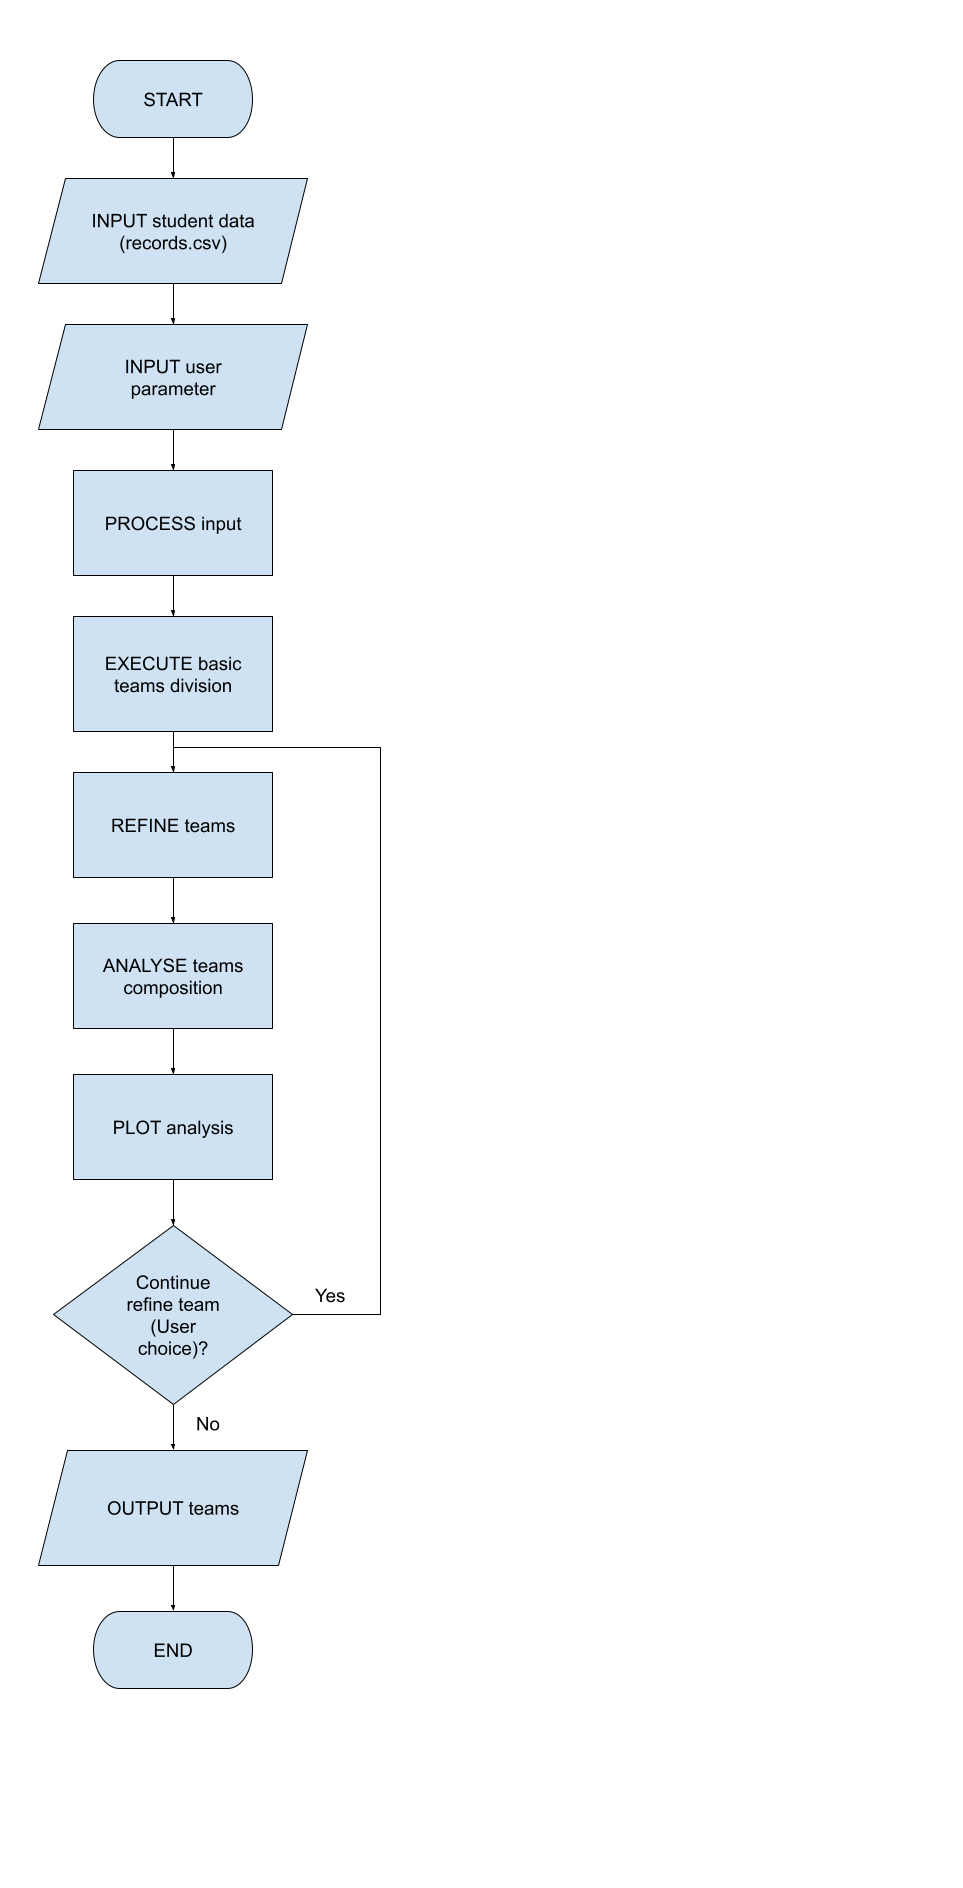


# **3. Overall Approach: Greedy and Evolutionary Algorithms**

1. **Greedy Algorithm** (Basic Team Division):
  - When choosing student for a team, make the locally optimal selection that contributes to a near-optimal team composition.
  - This involves balancing school and gender while ensuring that the current team's average CGPA moves closer to the tutorial group's average.
  - Reason for Using Greedy Algorithm:
    - **Simplicity:** Although there are three criteria, gender and school are relatively straightforward, leading to simpler logic for making the next selection.
    - **Fast:** It has low time complexity and, therefore suitable for generating the initial solution.
    - **Result:** While it may not guarantee the optimal solution, it can generate near-optimal solutions efficiently.

2. **Evolutionary Algorithm** (Refining the Team Composition):
  - This approach uses **Evolutionary Strategies** that involve mutation, fitness function, and selection.
  - **Initial Parent Generation:** Start with a "parent" team list generated by the greedy algorithm.
  - **Mutation:** Create multiple "child" team lists by applying random changes (mutations) to the "parent", such as swapping team members.
  - **Fitness Function:** Evaluate the fitness of the "child" team list based on the 3 criteria: gender diversity, school diversity, and CGPA balance.
  - **Selection:** The "child" with the highest fitness is more likely to become the "parent" for the next generation.
  - **Generational Improvement**: Repeat this process for multiple generations to explore potential better team composition.
  - Reason for Using Evolutionary Strategies:
    - **Simplicity:** Allows refinement of the team list without relying on complex logic, heavy memoization, or deeply nested loops.
    - **Flexibility:** Perform well with extreme cases since it can adjust to varying conditions and requirements.
    - **Not Limited:** Capable of escaping local minima because they are not confined to a specific logic or deterministic approach.
    - **Customizable:** Allows for customizable priorities across different criteria by adjusting fitness function.
    - **Result:** It can significantly improve the result. Refer to section 13.2 for more information.


# **4. Main**

The entry point of the program, including:
  - Import of necessary modules
  - Declaration of important constant
  - Main driver function
  - Implementation of UI

## **4.1 Code:**
**4.1.1** Import Modules and Declare Constants

In [73]:
import os
import copy
import random
import ipywidgets as widgets
from IPython.display import display as ipy_display, clear_output as ipy_clear_output, Javascript
import matplotlib.pyplot as plt
import seaborn as sns

# Constant for I/O
INPUT_FILE_PATH = "records.csv"
OUTPUT_FILE_PATH = "FCS4_Team5_YongCheeSeng.csv"

# Constant for user input
TEAM_SIZE_RANGE = {"min": 4, "max": 10, "default": 5}
TEAM_SIZE_PREFERENCE_CHOICE = {"Overassign": True, "Underassign": False}
REFINE_TEAM_QUALITY_CHOICE = {'Minimal': 5, 'Low': 15, 'Moderate': 25, 'High': 35, 'Maximum': 50}
REFINE_TEAM_QUALITY_DEFAULT_CHOICE = 'Moderate'
REFINE_TEAM_PRIORITY_RANGE = {"min": 1, "max": 10, "default": 5}

# Constant for refine team
DEFAULT_GENDER_WEIGHTAGE = 2.2
DEFAULT_SCHOOL_WEIGHTAGE = 2
DEFAULT_CGPA_WEIGHTAGE = 0.45

# Constant for UI
TITLE = widgets.HTML(value="<h1 style='text-align: center'>Team Division Algorithm</h1>")
LINE_BREAK = widgets.Box(layout=widgets.Layout(height='40px'))

**4.1.2** `init()`

**Purpose:** Create UI to accept input and invoke `main()`

**Input:**
1. `None`

**Output:**
1. `None`

In [74]:
def init():
    Output.display(TITLE)

    page_title = widgets.HTML(value="<h2>Settings</h2>")
    Output.display(page_title)

    team_size_ui = TeamSizeUI()
    refine_team_ui = RefineTeamUI()

    start_button = widgets.Button(
        description="Start Division",
        button_style='success',
        icon=''
    )

    def start_division(change):
        team_size = team_size_ui.get_team_size()
        allow_overassign = team_size_ui.get_team_size_preference()
        enable_refine_team = refine_team_ui.get_enable_refine_team()

        if enable_refine_team:
            refine_team_configurations = refine_team_ui.get_refine_team_configurations()
        else:
            refine_team_configurations = None

        main(team_size, allow_overassign, enable_refine_team, refine_team_configurations)

    start_button.on_click(start_division)

    Output.display(LINE_BREAK)

    Output.display(start_button)

**4.1.3** `main()`

**Purpose:** Driver function of the program and create UI for the result.

**Input:**
1. `team_size`
  - **Type:** `int`
  - Ideal size of a team.
2. `allow_overassign`
  - **Type:** `bool`
  - Determines whether teams should be over-assigned or under-assigned.
  - `True`: Teams are either equal to or larger than the `team_size`.
  - `False`: Teams are either equal to or smaller than the `team_size`.
3. `enable_refine_team`
  - **Type:** `bool`
  - Determines whether teams should be refined.
  - `True`: Teams are refined.
  - `False`: Teams are not refined.
4. `refine_team_configurations`
  - **Type:** `dict | None`
  - A dictionary containing 4 configuration values:
    - depth (`int`): Number of "child" per "parent", "parent," and generations.
    - gender_priority (`int`): User-input priority for gender diversity.
    - school_priority (`int`): User-input priority for school diversity.
    - cgpa_priority (`int`): User-input priority for balanced CGPA.
  - `None` is accepted only when `enable_refine_team` is `False`

**Output:**
1. A CSV file containing the final team assignment.

**Note:** The onclick-related functions are encapsulated for quick reference. Although this impacts the readability and makes the `main()` complex, the current version is still acceptable as the main flow of the program remains clear.

In [75]:
def main(team_size, allow_overassign, enable_refine_team, refine_team_configurations):
    main_ui = MainUI()

    def retry_division(change):
        main(team_size, allow_overassign, enable_refine_team, refine_team_configurations)

    if not os.path.exists(INPUT_FILE_PATH):
        main_ui.show_read_input_file_status(success=False)
        main_ui.generate_retry_button(retry_division)
        return

    students = get_students_from_input_file()
    main_ui.show_read_input_file_status(success=True)

    teams_by_tutorial_group = []
    for tutorial_group in students:
        teams = divide_teams_within_tutorial_group(students[tutorial_group], team_size, allow_overassign)
        teams_by_tutorial_group.append(teams)

    main_ui.show_basic_team_division_status(success=True)

    def refine_teams():
        main_ui.reset_refine_team_progress()

        for i in range(len(teams_by_tutorial_group)):
            teams = teams_by_tutorial_group[i]
            teams_by_tutorial_group[i] = refine_teams_within_tutorial_group(teams, refine_team_configurations)
            main_ui.update_refine_team_progress()

    if enable_refine_team:
        main_ui.show_refine_team_progress(len(teams_by_tutorial_group))
        refine_teams()

    main_ui.show_result(enable_refine_team)

    def back_to_setting(change):
        Output.clear_output()
        init()

    def further_refine_team(change):
        main_ui.hide_result()
        refine_teams()
        show_analysis()
        main_ui.unhide_result()

    def download_result(change):
        write_teams_to_file(teams_by_tutorial_group, OUTPUT_FILE_PATH)
        Output.display(Javascript("alert('Download Completed.')"))

    result_buttons = main_ui.get_result_buttons()
    result_buttons['back_to_setting_button'].on_click(back_to_setting)
    result_buttons['further_refine_button'].on_click(further_refine_team)
    result_buttons['download_button'].on_click(download_result)

    def show_analysis():
        teams_gender_diversity = analyse_teams_gender_diversity(teams_by_tutorial_group)
        teams_school_diversity = analyse_teams_school_diversity(teams_by_tutorial_group)
        teams_avg_cgpa_std_devs = analyse_teams_avg_cgpa_std_dev(teams_by_tutorial_group)

        main_ui.show_result_analysis(teams_gender_diversity, teams_school_diversity, teams_avg_cgpa_std_devs)

    show_analysis()

**4.1.4:** All classes of UI, including functions to create and modify UI elements.

**Note:** The class-based approach improves clarity and simplicity. The basic functional approach is not used because it is cumbersome and complex, as it requires numerous UI elements to be passed between functions.


In [76]:
class Output:
    output = widgets.Output()

    @staticmethod
    def display_self():
        with Output.output:
            ipy_clear_output()
        ipy_display(Output.output)

    @staticmethod
    def display(ele):
        with Output.output:
            ipy_display(ele)

    @staticmethod
    def clear_output():
        with Output.output:
            ipy_clear_output(wait=True)

In [77]:
class TeamSizeUI:
    def __init__(self):
        self.__generate_ui()

    def __generate_ui(self):
        team_size_subtitle = widgets.HTML(value="<h3>Team Size</h3>")

        team_size_description_text = widgets.HTML(value="<p>Choose an ideal team size. If the number of students cannot be evenly divided, some teams may be slightly larger or smaller to accommodate everyone.</p>")

        team_size_slider = widgets.IntSlider(
            min=TEAM_SIZE_RANGE['min'],
            max=TEAM_SIZE_RANGE['max'],
            value=TEAM_SIZE_RANGE['default'],
            description='Team Size:'
        )

        team_size_preference = widgets.ToggleButtons(
            options=TEAM_SIZE_PREFERENCE_CHOICE.keys(),
            description='Preference:',
            tooltips=['Actual team sizes are at least ideal team size', 'Actual team sizes are at most ideal team size'],
        )

        Output.display(team_size_subtitle)
        Output.display(team_size_description_text)
        Output.display(team_size_slider)
        Output.display(team_size_preference)

        self.__team_size_slider = team_size_slider
        self.__team_size_preference = team_size_preference

    def get_team_size(self):
        return self.__team_size_slider.value

    def get_team_size_preference(self):
        return TEAM_SIZE_PREFERENCE_CHOICE[self.__team_size_preference.value]

In [78]:
class RefineTeamUI:
    def __init__(self):
        self.__generate_ui()

    def __generate_ui(self):
        refine_team_subtitle = widgets.HTML(value="<h3>Refine Team</h3>")

        refine_team_enable_toggle = widgets.ToggleButton(
            value=True,
            description='Enable',
            button_style='success',
            tooltip='Enable refinement of team composition',
        )

        refine_team_quality_description_text = widgets.HTML(value="<p>Choose your preferred level of refinement. Refinement with higher quality takes longer to complete. Please note that results may vary each time, as refinement is based on randomness.</p>")

        refine_team_quality_toggle = widgets.ToggleButtons(
            options=REFINE_TEAM_QUALITY_CHOICE.keys(),
            value=REFINE_TEAM_QUALITY_DEFAULT_CHOICE,
            description='Quality:',
            disabled=False,
        )

        refine_team_priority_description_text = widgets.HTML(value="<p>Assign priority to each criterion. A higher value indicates a higher priority.</p>")

        refine_team_gender_priority_slider = widgets.IntSlider(
            min=REFINE_TEAM_PRIORITY_RANGE['min'],
            max=REFINE_TEAM_PRIORITY_RANGE['max'],
            value=REFINE_TEAM_PRIORITY_RANGE['default'],
            description='Gender:'
        )

        refine_team_school_priority_slider = widgets.IntSlider(
            min=REFINE_TEAM_PRIORITY_RANGE['min'],
            max=REFINE_TEAM_PRIORITY_RANGE['max'],
            value=REFINE_TEAM_PRIORITY_RANGE['default'],
            description='School:'
        )

        refine_team_cgpa_priority_slider = widgets.IntSlider(
            min=REFINE_TEAM_PRIORITY_RANGE['min'],
            max=REFINE_TEAM_PRIORITY_RANGE['max'],
            value=REFINE_TEAM_PRIORITY_RANGE['default'],
            description='CGPA:'
        )

        refine_team_widgets = [refine_team_quality_description_text,
                              refine_team_quality_toggle,
                              refine_team_priority_description_text,
                              refine_team_gender_priority_slider,
                              refine_team_school_priority_slider,
                              refine_team_cgpa_priority_slider]
        refine_team_widgets_box = widgets.VBox(refine_team_widgets)

        def show_refine_team_ui(change):
            if change['new']:
                refine_team_enable_toggle.description = 'Enable'
                refine_team_enable_toggle.button_style = 'success'
                refine_team_widgets_box.layout.display = ''
            else:
                refine_team_enable_toggle.description = 'Disable'
                refine_team_enable_toggle.button_style = 'danger'
                refine_team_widgets_box.layout.display = 'none'

        refine_team_enable_toggle.observe(show_refine_team_ui, names="value")

        Output.display(refine_team_subtitle)
        Output.display(refine_team_enable_toggle)
        Output.display(refine_team_widgets_box)

        self.__enable_refine_team_toggle = refine_team_enable_toggle
        self.__refine_team_quality_toggle = refine_team_quality_toggle
        self.__refine_team_gender_priority_slider = refine_team_gender_priority_slider
        self.__refine_team_school_priority_slider = refine_team_school_priority_slider
        self.__refine_team_cgpa_priority_slider = refine_team_cgpa_priority_slider

    def get_enable_refine_team(self):
        return self.__enable_refine_team_toggle.value

    def get_refine_team_configurations(self):
        return {'depth': REFINE_TEAM_QUALITY_CHOICE[self.__refine_team_quality_toggle.value],
                'gender_priority': self.__refine_team_gender_priority_slider.value,
                'school_priority': self.__refine_team_school_priority_slider.value,
                'cgpa_priority': self.__refine_team_cgpa_priority_slider.value,
        }

In [79]:
class MainUI:
    def __init__(self):
        self.__generate_ui()

    def __generate_ui(self):
        Output.clear_output()
        Output.display(TITLE)

    def __generate_error_message(self, message):
        Output.display(widgets.HTML(value=f"<p><b>Error:</b> {message}</p>"))

    def generate_retry_button(self, retry_division):
        retry_button = widgets.Button(
            description="Retry",
            button_style='danger',
            icon=''
        )
        retry_button.on_click(retry_division)
        Output.display(retry_button)

    def show_read_input_file_status(self, success):
        if success:
            Output.display(widgets.Label(value=f"Read {INPUT_FILE_PATH}: COMPLETED"))
        else:
            Output.display(widgets.Label(value=f"Read {INPUT_FILE_PATH}: FAIL"))
            self.__generate_error_message(f"File '{INPUT_FILE_PATH}' not found. Make sure it is in the same directory and try again.")

    def show_basic_team_division_status(self, success):
        if success:
            Output.display(widgets.Label(value="Basic Team Division: COMPLETED"))
        else:
            Output.display(widgets.Label(value=f"Basic Team Division: FAIL"))
            self.__generate_error_message("Basic Team Division failed. Please try again.")

    def show_refine_team_progress(self, tutorial_group_num):
        refine_team_progress = widgets.IntProgress(
            value=0,
            min=0,
            max=tutorial_group_num,
            description='',
            bar_style='success',
            orientation='horizontal',
            indent=False
        )

        refine_team_text = widgets.Label(value=f"Tutorial Group: 0/{tutorial_group_num}")
        refine_team_box = widgets.HBox([widgets.Label(value="Refining Team:"), refine_team_progress, refine_team_text])
        Output.display(refine_team_box)

        self.__refine_team_progress = refine_team_progress
        self.__refine_team_text = refine_team_text
        self.__max_refine_team_progress = tutorial_group_num

    def update_refine_team_progress(self):
        self.__refine_team_progress.value += 1
        self.__refine_team_text.value = f"Tutorial Group: {self.__refine_team_progress.value}/{self.__max_refine_team_progress}"

        if self.__refine_team_progress.value == self.__max_refine_team_progress:
            self.__refine_team_text.value = "COMPLETED"

    def reset_refine_team_progress(self):
        self.__refine_team_progress.value = 0
        self.__refine_team_text.value = f"Tutorial Group: 0/{self.__max_refine_team_progress}"

    def show_result(self, enable_refine_team):
        complete_text = widgets.HTML(value="<p>Team division completed. Statistic of result are shown below. You can choose further refine the team or output to a .csv file.</p>")
        result_subtitle = widgets.HTML(value="<h2>Result</h2>")

        teams_gender_diversity_output = widgets.Output()
        teams_school_diversity_output = widgets.Output()
        teams_avg_cgpa_std_devs_output = widgets.Output()

        result_tab = widgets.Tab()
        result_tab.children = [teams_gender_diversity_output, teams_school_diversity_output, teams_avg_cgpa_std_devs_output]
        result_tab_titles = ["Gender Diversity", "School Diversity", "CGPA Balance"]

        for i, title in enumerate(result_tab_titles):
            result_tab.set_title(i, title)

        result_buttons_box = self.__generate_result_buttons(enable_refine_team)

        result_box = widgets.VBox([complete_text, result_subtitle, result_tab, result_buttons_box])
        self.__result_box = result_box
        Output.display(result_box)

        self.__teams_gender_diversity_output = teams_gender_diversity_output
        self.__team_school_diversity_output = teams_school_diversity_output
        self.__team_mean_cgpa_std_output = teams_avg_cgpa_std_devs_output

    def __generate_result_buttons(self, enable_refine_team):
        back_to_setting_button = widgets.Button(
            description="Back to Setting",
            button_style='',
            icon=''
        )

        further_refine_button = widgets.Button(
            description="Further Refine Team",
            button_style='',
            icon=''
        )

        download_button = widgets.Button(
            description="Download",
            button_style='success',
            icon=''
        )

        self.__result_buttons = {
            'back_to_setting_button': back_to_setting_button,
            'further_refine_button': further_refine_button,
            'download_button': download_button
        }

        if enable_refine_team:
            result_buttons_box = widgets.HBox([back_to_setting_button, further_refine_button, download_button])
        else:
            result_buttons_box = widgets.HBox([back_to_setting_button, download_button])

        return result_buttons_box

    def get_result_buttons(self):
        return self.__result_buttons

    def unhide_result(self):
        self.__result_box.layout.display = ''

    def hide_result(self):
        self.__result_box.layout.display = 'None'

    def show_result_analysis(self, teams_gender_diversity, teams_school_diversity, teams_avg_cgpa_std_devs):
        with self.__teams_gender_diversity_output:
            ipy_clear_output()
            plot_teams_gender_diversity_as_line_plot(teams_gender_diversity)

        with self.__team_school_diversity_output:
            ipy_clear_output()
            plot_teams_school_diversity_as_line_plot(teams_school_diversity)

        with self.__team_mean_cgpa_std_output:
            ipy_clear_output()
            plot_teams_avg_cgpa_std_devs_as_box_and_strip_plot(teams_avg_cgpa_std_devs)

# **5. Input and Process Data**

## **5.1 Analysis of Input (records.csv):**
- The file contains six data for each student:
  - Tutorial Group
  - Student ID
  - School
  - Name
  - Gender
  - CGPA
- The first row is the header row, listing the titles of each data (e.g., "CGPA").
- Each subsequent row contains data for an individual student.
- Data within each row are separated by commas (,).
- The order of the titles matches the order of the data in each student's record.

## **5.2 Input:**
Read the file `records.csv` and convert it to a suitable format:
- Each student can be represented by a dictionary for the following reasons:
  - **Readability:** Using keys like `student['CGPA']` is more descriptive than using index-based access like `student[2]`.
  - **Simplicity:** While using a `class` as an alternative could reduce some overhead, it introduces complexity.
- All student records are stored together in a `list` for easy iteration.

## **5.3 Process Input:**
When selecting students to form teams, several aspects should be executed efficiently:
- **Division by Tutorial Group:** Divide students by their tutorial groups, as teams are formed within each tutorial group.
- **Selection by School and Gender:** Filter students by specific school and specific gender.
- **Selection by CGPA:** Find students with the highest, lowest, or nearest CGPA to a specific target.

A `dictionary` is a suitable data structure for this purpose, with the following structure and reasons:

- **Structure:** `students_by_tutorial_group[tutorial_group][school][gender]` points to a list of students filtered by tutorial group, school, and gender.
  - `tutorial_group` is the outermost layer since division happens within each tutorial group.
  - `school` and `gender` are arranged so that the school is filtered first.

- **Example format:**
```python
{
    'G-1': {
        'CCDS': {
            'Male': [list of students],
            'Female': [list of students]
        },
        'SSS': {
            'Male': [list of students],
            'Female': [list of students]
        },
        ...
    },
    'G-10': {
        'CCDS': {
            'Male': [list of students],
            'Female': [list of students]
        },
        ...
    },
    ...
}
```

- **Efficient CGPA Selection:** To quickly find students with the highest or lowest CGPA, the list of students can be sorted by CGPA before division.

## **5.4 Code:**
**5.4.1:** `get_students_from_input_file()`

**Purpose:** Driver function to read `records.csv` and process input into the suitable data structure.

**Input:**
1. `None`

**Output:**
1. `students_by_tutorial_group`
  - **Type:** `dict`
  - Represent the structure of students categorised by tutorial group, school, and gender.
  - `students_by_tutorial_group[tutorial_group][school][gender]` is a list of students filtered by tutorial group, school, and gender.
  - Refer to section 5.3 for a specific format.

In [80]:
def get_students_from_input_file():
    students = load_students_from_file(INPUT_FILE_PATH)
    students_by_tutorial_group = categorise_students(students)
    sort_categorised_students_by_cgpa(students_by_tutorial_group)

    return students_by_tutorial_group

**5.4.2:** `load_students_from_file()`

**Purpose:** Read every line of a file containing student data and return a list of students.

**Input:**
1. `file_path`
  - **Type:** `str`
  - Path to the file containing student data.

**Output:**
1. `students`
  - **Type:** `list[dict]`
  - A list of students.
  - `students[i]` is a student.
  - `students[i][data_title] = data`

In [81]:
def load_students_from_file(file_path):
    students = []

    with open(file_path) as file:
        #strip() to remove '\n'
        lines = [line.strip().split(',') for line in file]

    # The first line of the file is the data title
    student_data_titles = lines.pop(0)

    for line in lines:
        student = {}
        for data, title in zip(line, student_data_titles):
            student[title] = data

        # Conversion for further mathematical calculation
        student['CGPA'] = float(student['CGPA'])

        students.append(student)

    return students

**5.4.3:** `categorise_students()`

**Purpose:** Convert a list of students into a dictionary that categorise students.

**Input:**
1. `students`
  - **Type:** `list[dict]`
  - A list of students.
  - `students[i]` is a student.
  - `students[i][data_title] = data`

**Output:**
1. `students_by_tutorial_group`
  - **Type:** `dict`
  - Represent the structure of students categorised by tutorial group, school, and gender.
  - `students_by_tutorial_group[tutorial_group][school][gender]` is a list of students filtered by tutorial group, school, and gender.
  - Refer to section 5.3 for a specific format.

In [82]:
def categorise_students(students):
    students_by_tutorial_group = {}

    for student in students:
        tutorial_group = student['Tutorial Group']
        school = student['School']
        gender = student['Gender']

        if tutorial_group not in students_by_tutorial_group:
            students_by_tutorial_group[tutorial_group] = {}

        if school not in students_by_tutorial_group[tutorial_group]:
            students_by_tutorial_group[tutorial_group][school] = {"Male": [], "Female": []}

        students_by_tutorial_group[tutorial_group][school][gender].append(student)

    return students_by_tutorial_group

**5.4.4:** `sort_categorised_students_by_cgpa()`

**Purpose:** Sort students in their category by their CGPA in ascending order **in-place**.

**Input:**
1. `students_by_tutorial_group`
  - **Type:** `dict`
  - Represent the structure of students categorised by tutorial group, school, and gender.
  - `students_by_tutorial_group[tutorial_group][school][gender]` is a list of students filtered by tutorial group, school, and gender.
  - Refer to section 5.3 for a specific format.

**Output:**
1. `None`


In [83]:
def sort_categorised_students_by_cgpa(students_by_tutorial_group):
    for tutorial_group in students_by_tutorial_group:
        for school in students_by_tutorial_group[tutorial_group]:
            for gender in students_by_tutorial_group[tutorial_group][school]:
                  students = students_by_tutorial_group[tutorial_group][school][gender]
                  insertion_sort(students, key="CGPA")

# **6. Basic Team Division (Greedy Algorithm)**

## **6.1 Gender distribution:**
1. **Distributing Gender Equally Across Teams:**
  - The number of students from each gender is pre-determined for every team to ensure balance.
  - **Pigeonhole Theorem** is used to determine the minimum number of students from the gender that will be over-assigned in at least one team.
  - **Example:** For 4 females to be divided into 3 teams, one team must have at least 2 females. Hence, we should assign no more than 2 females to any team to avoid over-assigning to one team.
2. **Gender Priority in Team Selection Based on School**:
  - When selecting a team member from a specific school, priority is given to the gender that has a higher proportion within that school.
  - This aims to balance the remaining gender distribution within the school after members are selected.
  - **Example**: If a student is to be chosen from a school like CCDS with 3 males and 8 females, females will have higher priority in selection.

## **6.2 School Distribution:**
1. **Distributing School Equally Across Teams:**
  - When selecting a new team member, we cycled through the schools in descending order of the remaining number of students, starting with the school that has the most students left.
  - This ensures that, after each selection:
    - The remaining number of students in each school gradually converges toward a similar count.
    - Students from different schools are selected unless it's impossible to do so.
  - **Example:** If CCDS has 2 students remaining and EEE has 1 student left, to form a team of 3, we would select students in the order: `CCDS → EEE → CCDS`.
2. **Distributing Schools Based on Gender Constraints:**
  - Gender takes higher priority. If a school doesn't have a student of the required gender, it will be skipped during that selection round.
3. **Counter Towards Extreme Case:**
  - The basic approach may fail when some schools have more students than the number of available teams, leading to imbalances.
  - **Example:** If CCDS has 4 students, EEE has 1 student, and NBS has 1 student, the ideal teams would be `[2 CCDS, 1 EEE]` and `[2 CCDS, 1 NBS]`. However, the current approach might generate `[1 CCDS, 1 EEE, 1 NBS]` and `[3 CCDS]`, which over-assigns CCDS in the second team.
  - **Solution:** If a school has more students than the number of available teams, we allow **1 additional selection** from that school to help balance representation.
  - **Example:** If CCDS has 4 students, EEE has 1 student, and NBS has 1 student. to form teams of 3, selection will be made in the order: `CCDS → CCDS → EEE`, followed by `CCDS → CCDS → NBS`.

## **6.3 CGPA Distribution:**
1. **Distributing CGPA Equally Across Teams**:
  - **Concept**: To balance the sum of pairs from a list of numbers, we pair the smallest and largest numbers together.
  - **Example:** Given the list `[1, 2, 5, 7]`, the optimal pairs are `[1, 7]` and `[2, 5]`. This approach ensures that the sums of the pairs are more evenly distributed.
  - **Odd Selections (1st, 3rd, 5th, etc.):** Select the student with the highest CGPA.
  - **Even Selections (2nd, 4th, 6th, etc.) or Last Selection:** Choose students whose CGPA brings the team average closer to the overall average of the tutorial group.
  - **Reasoning:** Alternating between high and balancing selections prevents a scenario where only extreme CGPA students (very high or very low) are left for the final rounds, which could result in unbalanced teams.
  - **Example:** Students are likely to be selected in the following CGPA order: `High → Low → High → Low → Middle`.
  - **Note:** The choice of whether to select the highest or lowest CGPA first can significantly affect the results. The optimal approach may vary depending on data set and can only be determined through trial and error.

## **6.4 Evaluation of Algorithm:**
1. **Gender Distribution:** The approach is optimal as proven by the Pigeonhole Principle, which ensures that students are evenly distributed across genders in teams.
2. **School Distribution:** The method is ideally optimal for a larger number of teams. However, with a lower number of teams, there may be a risk of imbalance if certain schools have significantly more students.
3. **CGPA Distribution:** This approach may not be optimal, as the number of students decreases after each team formation. Remaining students of a specific gender and school may not be suitable for achieving a balanced CGPA, yet they may still be selected.

## **6.5 Overview of Greedy Algorithm:**
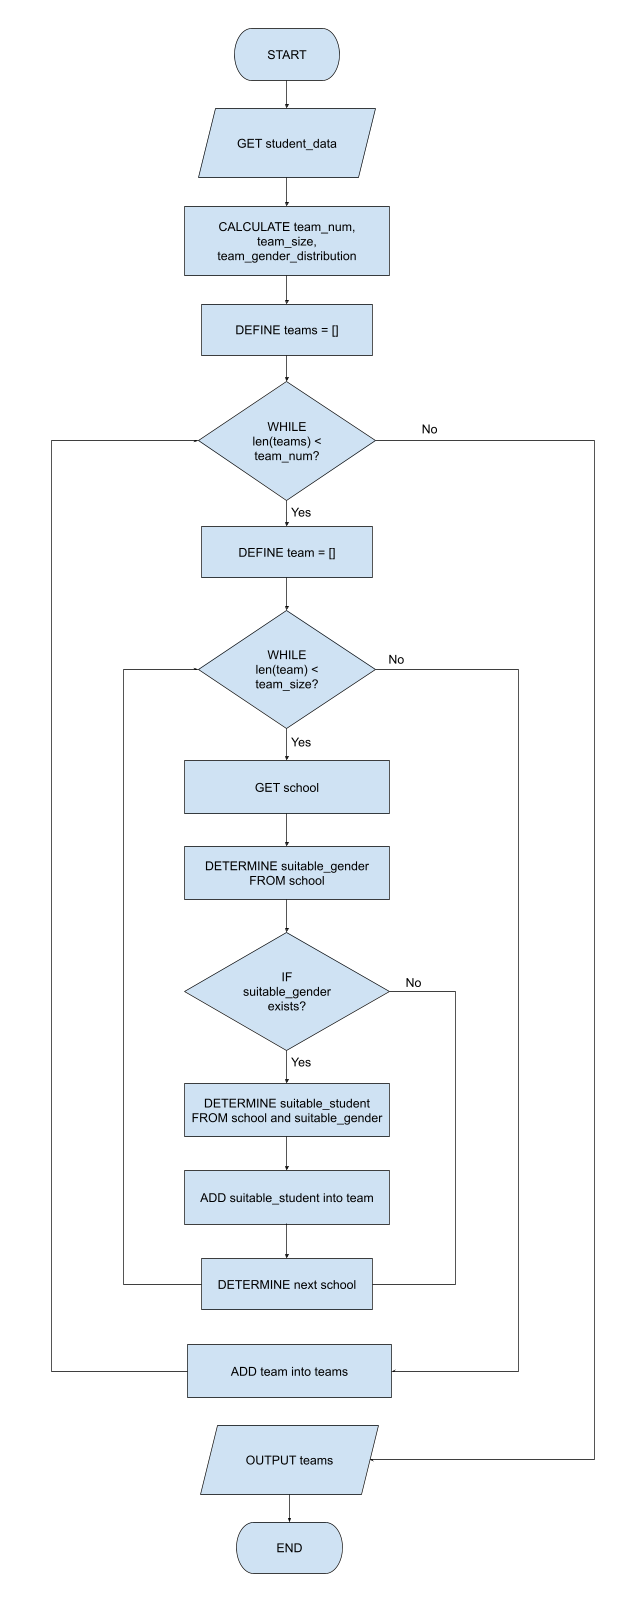

## **6.6 Code:**
**6.6.1** `divide_teams_within_tutorial_group()`

**Purpose:** Driver function for basic division of teams.

**Input:**
1. `students_by_tutorial_group`
  - **Type:** `dict`
  - Represent the structure of students categorised by tutorial group, school, and gender.
  - `students_by_tutorial_group[tutorial_group][school][gender]` is a list of students filtered by tutorial group, school, and gender.
  - Refer to section 5.3 for a specific format.
2. `team_size`
  - **Type:** `int`
  - Ideal size of a team.
3. `allow_overassign`
  - **Type:** `bool`
  - Determines whether teams should be over-assigned or under-assigned.
  - `True`: Teams are either equal to or larger than the `team_size`.
  - `False`: Teams are either equal to or smaller than the `team_size`.
**Output:**
1. `teams_within_tutorial_group`
  - **Type:** `list[list[dict]]`
  - A list of teams within the tutorial group.
  - `teams_within_tutorial_group[i]` is i-th team.
  - `teams_within_tutorial_group[i][j]` is j-th student in the i-th team.


In [84]:
def divide_teams_within_tutorial_group(students_within_tutorial_group, team_size, allow_overassign):
    tutorial_group_stats = calculate_tutorial_group_stats(students_within_tutorial_group)
    team_sizes = calculate_team_sizes(team_size, allow_overassign, tutorial_group_stats["student_count"])
    team_gender_distributions = calculate_team_gender_distributions(team_sizes, tutorial_group_stats["female_count"])
    teams_within_tutorial_group = perform_team_division(students_within_tutorial_group, team_gender_distributions, tutorial_group_stats['avg_cgpa'], tutorial_group_stats['school_student_counts'])

    return teams_within_tutorial_group

**6.6.2** `calculate_tutorial_group_stats()`

**Purpose:** Calculate various statistics within a tutorial group, including the average CGPA, the total number of students, the distribution of students by school, and the count of male and female students.

**Input:**
1. `students_by_tutorial_group`
  - **Type:** `dict`
  - Represent the structure of students categorised by tutorial group, school, and gender.
  - `students_by_tutorial_group[tutorial_group][school][gender]` is a list of students filtered by tutorial group, school, and gender.
  - Refer to section 5.3 for a specific format.
**Output (Dictionary):**
1. `avg_cgpa`
  - **Type:** `float`
  - Average CGPA of students within the tutorial group.
2. `student_count`
  - **Type:** `int`
  - Total number of students within the tutorial group.
3. `school_student_counts`
  - **Type:** `list[dict]`
  - Number of students by school within the tutorial group.
  - `school_student_counts[i]` is a dictionary with 2 values:
    - school (`str`): Name of school.
    - student_count (`int`): Number of students in the school.
4. `male_count`
  - **Type:** `int`
  - Number of male students within the tutorial group.
5. `female_count`
  - **Type:** `int`
  - Number of female students within the tutorial group.

In [85]:
def calculate_tutorial_group_stats(students_within_tutorial_group):
    cgpa_sum = 0
    school_student_counts = []
    male_count = 0
    female_count = 0

    for school in students_within_tutorial_group:
        male_students = students_within_tutorial_group[school]["Male"]
        female_students = students_within_tutorial_group[school]["Female"]

        for male_student in male_students:
            cgpa_sum += male_student["CGPA"]
        for female_student in female_students:
            cgpa_sum += female_student["CGPA"]

        school_student_count = len(male_students) + len(female_students)
        school_student_counts.append({"school": school, "student_count": school_student_count})

        male_count += len(male_students)
        female_count += len(female_students)

    student_count = male_count + female_count

    return {
        "avg_cgpa": cgpa_sum / student_count,
        "student_count": student_count,
        "school_student_counts": school_student_counts,
        "male_count": male_count,
        "female_count": female_count
    }

**6.6.3** `calculate_team_sizes()`

**Purpose:** Calculate the sizes of each team using the Pigeonhole Principle. The maximum difference in team sizes is at most 1. If the total number of students is less than the specified team size, the list `[student_count]` will be returned.

**Input:**
1. `team_size`
  - **Type:** `int`
  - Ideal size of a team.
2. `allow_overassign`
  - **Type:** `bool`
  - Determines whether teams should be over-assigned or under-assigned.
  - `True`: Teams are either equal to or larger than the `team_size`.
  - `False`: Teams are either equal to or smaller than the `team_size`.
3. `student_count`
  - **Type:** `int`
  - Total number of students within the tutorial group.
**Output:**
1. `team_sizes`
  - **Type:** `list[int]`
  - A list containing the sizes of each team.
  - `team_sizes[i]` is the size of i-th team.



In [86]:
def calculate_team_sizes(team_size, allow_overassign, student_count):
    if(student_count <= team_size):
        return [student_count]

    if allow_overassign:
        # Floor division: Extra students will be distributed among the existing teams.
        # For example, if there are 10 students and the team size is 3, we can form 3 teams [3, 3, 4].
        team_num = student_count // team_size
    else:
        # Ceil division: Extra student will form an additional team
        # For example, if there are 10 students and the team size is 3, we would need 4 teams (3, 3, 2, 2)
        team_num = (student_count + team_size - 1) // team_size

    # Calculate the base number of students per team (average)
    avg_student_count = student_count // team_num

    # Calculate how many teams will have one extra student (overassigned teams)
    overassigned_team_num = student_count % team_num

    team_sizes = []

    for i in range(overassigned_team_num):
        team_sizes.append(avg_student_count + 1)
    for i in range(team_num - overassigned_team_num):
        team_sizes.append(avg_student_count)

    return team_sizes

# calculate_team_sizes(5, True, 50)

**6.6.4** `calculate_team_gender_distributions()`

**Purpose:** Calculate the number of male and female students in each team using Pigeonhole Principle

**Input:**
1. `team_sizes`
  - **Type:** `list[int]`
  - A list containing the sizes of each team.
2. `female_count`
  - **Type:** `int`
  - Number of female students within the tutorial group.
**Output:**
1. `team_gender_distributions`
  - **Type:** `list[list[int]]`
  - A list containing the number of male and female students in each team.
  - `team_gender_distributions[i]` is a dictionary with 2 values:
    - male (`int`): The number of male students in i-th team.
    - female `(int)` The number of female students in i-th team.
**Note:**
1. Reasoning for choosing `female_count`:
  - `female_count` is chosen instead of `male_count` because there are generally more females in the original data.
  - Allocating more females to larger teams promotes a more balanced team composition.
  - **Example:** A distribution of 4 females to 6 total members (4/6) is more balanced than 4 females to 5 total members (4/5).
  - **Note:** The female composition is arranged in descending order, similar to the team sizes.



In [87]:
def calculate_team_gender_distributions(team_sizes, female_count):
    team_num = len(team_sizes)

    # Calculate the base number of females per team (average)
    female_count_avg = female_count // team_num

    # Calculate how many teams will have one extra female (overassigned teams)
    overassigned_female_team_num = female_count % team_num

    team_gender_distributions = []

    # number of males = team size - number of females
    for i in range(overassigned_female_team_num):
        team_gender_distributions.append({
            "male": team_sizes[i] - (female_count_avg + 1),
            "female": female_count_avg + 1
        })
    for i in range(overassigned_female_team_num, team_num):
        team_gender_distributions.append({
            "male": team_sizes[i] - female_count_avg,
            "female": female_count_avg
        })

    return team_gender_distributions

**6.6.5** `perform_team_division()`

**Purpose:** Divide students into groups based on gender, school, and CGPA. For more information, refer to sections 6.2, 6.3, and 6.4.

**Input:**
1. `students_within_tutorial_group`
  - **Type:** `dict`
  - Represents the structure of students in a tutorial group. This follows the same structure as `students[tutorial_group]` in section 5.3. Refer to that section for more details.
2. `team_gender_distributions`
  - **Type:** `list[list[int]]`
  - A list containing the number of male and female students in each team.
  - `team_gender_distributions[i]` is a dictionary with 2 values:
    - male (`int`): The number of male students in i-th team.
    - female `(int)` The number of female students in i-th team.
3. `avg_cgpa`
  - **Type:** `float`
  - Average CGPA of students within the tutorial group.
4. `school_student_counts`
  - **Type:** `list[dict]`
  - Number of students by school within the tutorial group.
  - `school_student_counts[i]` is a dictionary with 2 values:
    - school (`str`): Name of school.
    - student_count (`int`): Number of students in the school.


**Output:**
1. `teams_within_tutorial_group`
  - **Type:** `list[list[dict]]`
  - A list of teams within the tutorial group.
  - `teams_within_tutorial_group[i]` is i-th team.
  - `teams_within_tutorial_group[i][j]` is j-th student in the i-th team.

In [88]:
def perform_team_division(students_within_tutorial_group, team_gender_distributions, avg_cgpa, school_student_counts):
    teams_within_tutorial_group = []
    team_num = len(team_gender_distributions)

    for team_gender_distribution in team_gender_distributions:
        team = []

        remaining_male_num = team_gender_distribution["male"] # Remaining number of males needed in the team
        remaining_female_num = team_gender_distribution["female"] # Remaining number of females needed in the team
        team_size = remaining_male_num + remaining_female_num

        current_team_cgpa_sum = 0

        school_index = 0
        school_set = set() # Set to track schools already included in the team

        insertion_sort(school_student_counts, key="student_count", reverse=True)

        while len(team) < team_size:
            school_index %= len(school_student_counts) # Wrap around if index exceeds maximum
            school = school_student_counts[school_index]["school"]

            target_gender = determine_target_gender(
                remaining_male_num,
                remaining_female_num,
                len(students_within_tutorial_group[school]["Male"]),
                len(students_within_tutorial_group[school]["Female"]))

            if target_gender is None:
                # No suitable gender found in this school; move to the next school
                school_index += 1
                continue
            elif target_gender == "Male":
                remaining_male_num -= 1
            else:
                remaining_female_num -= 1

            students = students_within_tutorial_group[school][target_gender]

            # Calculate the target CGPA for the new student to achieve the desired average CGPA (Average CGPA of tutorial group)
            target_team_cgpa_sum = (len(team) + 1) * avg_cgpa
            target_cgpa = target_team_cgpa_sum - current_team_cgpa_sum

            is_odd_selection = len(team) % 2 == 1
            is_last_selection = len(team) + 1 == team_size
            if is_odd_selection or is_last_selection:
                target_student_index = determine_target_student_index_with_cgpa(students, target_cgpa)
            else:
                #students is sorted by CGPA, students[-1] is the student with highest CGPA
                target_student_index = -1

            team.append(students[target_student_index])
            current_team_cgpa_sum += students[target_student_index]['CGPA']

            # Remove the student from the list to avoid duplicate selection
            del students[target_student_index]

            school_student_counts[school_index]["student_count"] -= 1

            if school_student_counts[school_index]["student_count"] == 0:
                del school_student_counts[school_index]
            elif school in school_set or school_student_counts[school_index]["student_count"] <= team_num - 1:
                # If the school has more students than team size and hasn't been selected again,
                # Select a student from the same school without incrementing the index;
                # Otherwise, increment the index
                school_index += 1

            school_set.add(school)

        teams_within_tutorial_group.append(team)

    return teams_within_tutorial_group

**6.6.6** `determine_target_gender()`

**Purpose:** Determine a suitable gender to add to the team. Return `None` if no suitable gender is found.

**Input:**
1. `remaining_male_num`
  - **Type:** `int`
  - The remaining number of males needed to form the team.
2. `remaining_female_num`
  - **Type:** `int`
  - The remaining number of females needed to form the team.
3. `school_male_count`
  - **Type:** `int`
  - The remaining number of males in a specific school.
4. `school_female_count`
  - **Type:** `int`
  - The remaining number of females in a specific school.

**Output:**
1. `target_gender`
  - **Type:** `str | None`
  - Suitable gender to add to the team.
  - "Male" or "Female" when a suitable gender is found; otherwise, `None`.



In [89]:
def determine_target_gender(remaining_male_num, remaining_female_num, school_male_count, school_female_count):
    # If there are no remaining males needed in the team, return "Female" if there are females in school
    if remaining_male_num == 0:
        if school_female_count == 0:
            return None
        else:
            return "Female"

    # If there are no remaining females needed in the team, return "Male" if there are males in school
    if remaining_female_num == 0:
        if school_male_count == 0:
            return None
        else:
            return "Male"

    # Return gender with higher proportion in school
    if school_male_count >= school_female_count:
        return "Male"
    else:
        return "Female"

**6.6.7** `determine_target_student_index_with_cgpa()`

**Purpose:** Determine students with a CGPA closest to the given CGPA.

**Input:**
1. `students`
  - **Type:** `list[dict]`
  - A list of students.
2. `target_cgpa`
  - **Type:** `float`
  - The target CGPA to compare against.

**Output:**
1. `target_student_index`
  - **Type:** `int`
  - Index of the student with CGPA closest to `target_cgpa` in `students`.



In [90]:
def determine_target_student_index_with_cgpa(students, target_cgpa):
    target_student_index = 0
    min_cgpa_diff = float("inf")

    for student_index in range(len(students)):
        cgpa_diff = abs(students[student_index]['CGPA'] - target_cgpa)
        if cgpa_diff < min_cgpa_diff:
            min_cgpa_diff = cgpa_diff
            target_student_index = student_index

    return target_student_index

# **7. Team Composition Analysis**

## **7.1 Gender Diversity:**
Gender diversity can be represented as the ratio of the number of males in a team to the team size.
- **Ideal Situation:**  In every team, the ratio of males to females is 1:1.
- **Ideal value:** 0.5
- **Notes:**
  - Ratio is used because team size may vary.
  - Alternatively, the ratio of females in the teams can be used, but it is inherently the same.
  - The ratio of males to females is not chosen due to some potential issues including division by zero.

## **7.2 School Diversity:**
School diversity can be represented as the ratio of the number of distinct schools in a team to the team size.
- **Ideal Situation:** In every team, all of the members come from different schools.
- **Ideal value:** 1
- **Notes:**
  - Ratio is used because team size may vary.

## **7.3  Balance CGPA Distibution:**
Balance CGPA distribution can be represented by the **standard deviation** of the average CGPA of the teams. Standard deviation measures CGPA spread across teams. A higher standard deviation indicates a wider distribution, meaning some teams have relatively higher or lower average CGPA, indicating a poorer CGPA distribution across teams.
- **Formula:**
$$\sigma = \sqrt{\frac{\sum_{i=1}^{N} (x_i)^2}{N} - (\frac{\sum_{i=1}^{N} x_i}{N})^2}$$
where (N) is the total number of teams and (x$_{i}$) is the average CGPA of i-th team

- **Ideal Situation:** Every team has the same average CGPA. If it is impossible, it should be as similar as possible.
- **Ideal value:** ≈0
- **Notes:**
  - Standard deviation is calculated for teams within each tutorial group rather than across all teams. This approach accounts for the fact that some tutorial groups may have inherently higher average CGPAs while others may have lower averages.

## **7.4 Code**
**7.4.1** `analyse_teams_gender_diversity()`

**Purpose:** Calculate the gender diversity of every team. Gender diversity is defined as the ratio of the number of males in a team to the team size.

**Input:**
1. `teams_by_tutorial_group`
  - **Type:** `list[list[list[dict]]]`
  - A list of teams partitioned by the tutorial group.
  - `teams_by_tutorial_group[i]` is the list of teams within i-th tutorial group.
  - `teams_by_tutorial_group[i][j]` is the a team.
  - `teams_by_tutorial_group[i][j][k]` is a student.

**Output:**
1. `teams_gender_diversity`
  - **Type:** `dict`
  - Dictionary with key-value pairs of:
    - **Key** (`float`): Gender diversity
    - **Value** (`int`): Corresponding number of teams
  - **Example:** `{0.5: 3}` indicates 3 teams with a gender diversity of 0.5.

In [91]:
def analyse_teams_gender_diversity(teams_by_tutorial_group):
    teams_gender_diversity = {}

    for teams_within_tutorial_group in teams_by_tutorial_group:
        for team in teams_within_tutorial_group:
            male_count = 0

            for student in team:
                if student['Gender'] == 'Male':
                    male_count += 1

            gender_diversity = male_count / len(team)
            if gender_diversity in teams_gender_diversity:
                teams_gender_diversity[gender_diversity] += 1
            else:
                teams_gender_diversity[gender_diversity] = 1

    return teams_gender_diversity

**7.4.2** `analyse_teams_school_diversity()`

**Purpose:** Calculate the school diversity of every team. School diversity is defined as the ratio of the number of distinct schools in a team to the team size.

**Input:**
1. `teams_by_tutorial_group`
  - **Type:** `list[list[list[dict]]]`
  - A list of teams partitioned by the tutorial group.
  - `teams_by_tutorial_group[i]` is the list of teams within i-th tutorial group.
  - `teams_by_tutorial_group[i][j]` is the a team.
  - `teams_by_tutorial_group[i][j][k]` is a student.

**Output:**
1. `teams_school_diversity`
  - **Type:** `dict`
  - Dictionary with key-value pairs of:
    - **Key** (`float`): School diversity
    - **Value** (`int`): Corresponding number of teams
  - **Example:** `{0.5: 3}` indicates 3 teams with a school diversity of 0.5.

In [92]:
def analyse_teams_school_diversity(teams_by_tutorial_group):
    teams_school_diversity = {}

    for teams_within_tutorial_group in teams_by_tutorial_group:
        for team in teams_within_tutorial_group:
            school_set = set()

            for student in team:
                school_set.add(student['School'])

            school_diversity = len(school_set) / len(team)
            if school_diversity in teams_school_diversity:
                teams_school_diversity[school_diversity] += 1
            else:
                teams_school_diversity[school_diversity] = 1

    return teams_school_diversity

**7.4.3** `analyse_teams_teams_avg_cgpa_std_dev()`

**Purpose:** Calculate the standard deviation of the average CGPA of teams within each tutorial group.

**Input:**
1. `teams_by_tutorial_group`
  - **Type:** `list[list[list[dict]]]`
  - A list of teams partitioned by the tutorial group.
  - `teams_by_tutorial_group[i]` is the list of teams within i-th tutorial group.
  - `teams_by_tutorial_group[i][j]` is the a team.
  - `teams_by_tutorial_group[i][j][k]` is a student.

**Output:**
1. `teams_avg_cgpa_std_devs`
  - **Type:** `list[float]`
  - A list of standard deviations of the average CGPA of teams within each tutorial group.
  - `teams_avg_cgpa_std_devs[0]` is the standard deviation of average CGPA of teams within i-th tutorial group.

In [93]:
def analyse_teams_avg_cgpa_std_dev(teams_by_tutorial_group):
    teams_avg_cgpa_std_devs = []

    for teams_within_tutorial_group in teams_by_tutorial_group:
        avg_cgpa_sum = 0
        avg_cgpa_square_sum = 0

        for team in teams_within_tutorial_group:
            sum_cgpa = 0
            for student in team:
                sum_cgpa += student['CGPA']
            avg_cgpa = sum_cgpa / len(team)

            avg_cgpa_sum += avg_cgpa
            avg_cgpa_square_sum += avg_cgpa ** 2

        team_num = len(teams_within_tutorial_group)
        variance = avg_cgpa_square_sum / team_num - (avg_cgpa_sum / team_num) ** 2

        # max(variance, 0) prevents negative variance due to floating-point inaccuracies.
        # Although variance is theoretically non-negative, cumulative rounding errors in floating-point arithmetic can sometimes cause it to be slightly negative.
        std_dev = max(variance, 0) ** 0.5
        teams_avg_cgpa_std_devs.append(std_dev)

    return teams_avg_cgpa_std_devs

# **8. Refine Team Division (Evolutionary Algorithm)**

## **8.1 Mutation:**
Randomly mutate the "parent" team list and generate "child" team list by:
  1. Selecting 2 random teams from the "parent".
  2. Choosing 1 random student from each selected team and swapping them.
  3. Repeating this process multiple times to create diverse child teams.

## **8.2 Fitness Function:**
The fitness of each team division is evaluated by comparing multiple criteria against a baseline (the result from the basic team division). The child teams are first evaluated using the functions in section 7, obtaining a score for each criterion. Each score is then expressed as a ratio by dividing it by the baseline score for that criterion. Finally, each ratio is multiplied by a different weight, resulting in the final fitness score.
1. **Gender Diversity:**
  - The score is calculated as the sum of the absolute differences between each team's gender diversity and the target value of 0.5.
  - A lower sum results in a higher fitness.
2. **School Diversity:**
  - The score is calculated as the sum of the school diversities across all teams.
  - A higher sum results in a higher fitness.
3. **Standard Deviation of Mean CGPA of Teams:**
  - The score is the standard deviation itself.
  - A lower standard deviation results in a higher fitness.
4. **Weights:**
  - The weights are obtained through trial and error to find an ideal balance.
  - Higher weights are given for gender and school diversity to help reduce CGPA variation while keeping diversity stable.
  - In the current implementation, the weights are tuned to produce optimal results for a team size of 5, as shown in section 13.2. However, this may not be the most universally optimal setting.
  - Additionally, the user has the option to adjust weights within a certain ratio, allowing them to set a custom priority for each criterion.

## **8.3 Selection:**
Select the next generation "parent" by:
1. Shuffling the "child" population to introduce randomness.
2. Dividing the "child" population into multiple subsets (number of subsets equals to number of "parent").
3. Selecting the best individual (highest fitness) from each subset.

**Note:** This is a simplified version of **tournament selection**. While classic tournament selection may introduce more randomness and foster a more optimal result by enhancing diversity, this simplified approach has proven to yield acceptable results while maintaining ease of implementation.

## **8.4 Additional Notes:**
- A higher number of "child" per "parent," "parent," and generations is likely to lead to better results, as each increment facilitates greater exploration of different team compositions.
- However, increasing these numbers also makes the process more time-consuming. While threading can help reduce execution time, performance may become unacceptable when the counts reach around 50. For more information, refer to section 13.1.
- The current implementation uses equal numbers of "child" per "parent," "parent," and generations, as this balance seems to yield satisfactory results. However, a more optimal approach may be discovered through further trial and error.

## **8.5 Code:**
**8.5.1** `refine_teams_within_tutorial_group()`

**Purpose:** Driver function to refine teams.

**Input:**
1. `teams_within_tutorial_group`
  - **Type:** `list[list[dict]]`
  - A list of teams within the tutorial group.
  - `teams_within_tutorial_group[i]` is i-th team.
  - `teams_within_tutorial_group[i][j]` is j-th student in the i-th team.
2. `refine_team_configurations`
  - **Type:** `dict`
  - A dictionary containing 4 configuration values:
    - depth (`int`): Number of "child" per "parent", "parent," and generations.
    - gender_priority (`int`): User-input priority for gender diversity.
    - school_priority (`int`): User-input priority for school diversity.
    - cgpa_priority (`int`): User-input priority for balanced CGPA.

**Output:**
1. `refined_teams_within_tutorial_group`
  - **Type:** `list[list[dict]]`
  - A list of teams within the tutorial group after refined.
  - `refined_teams_within_tutorial_group[i]` is i-th refined team.
  - `refined_teams_within_tutorial_group[i][j]` is j-th student in the i-th refined team.

In [94]:
def refine_teams_within_tutorial_group(teams_within_tutorial_group, refine_team_configurations):
    depth = refine_team_configurations['depth']
    parent_num = depth
    child_num_per_parent = depth
    generation_num = depth

    parents = initialise_parents(teams_within_tutorial_group, parent_num)
    base_teams_criteria_scores = calculate_teams_criteria_scores(teams_within_tutorial_group)
    current_fittest_teams = {
        "teams": teams_within_tutorial_group,
        "fitness": calculate_teams_fitness(base_teams_criteria_scores, base_teams_criteria_scores, refine_team_configurations)
    }

    for _ in range(generation_num):
        children = mutation(parents, base_teams_criteria_scores, refine_team_configurations, current_fittest_teams, child_num_per_parent)
        parents = selection_tournament(children, parent_num, child_num_per_parent)

    return current_fittest_teams["teams"]

**8.5.2** `initialised_parents()`

**Purpose:** Generate the first list of parents, which are the initial teams to be refined.

**Input:**
1. `teams_within_tutorial_group`
  - **Type:** `list[list[dict]]`
  - The initial teams to be refined.
  - A list of teams within the tutorial group.
  - `teams_within_tutorial_group[i]` is i-th team.
  - `teams_within_tutorial_group[i][j]` is j-th student in the i-th team.
2. `parent_num`
  - **Type:** `int`
  - Number of parent to be generated.

**Output:**
1. `parents`
  - **Type:** `list[list[list[dict]]]`
  - `len(parents) = parent_num`
  - `parents[i] = teams_within_tutorial_group`

In [95]:
def initialise_parents(teams_within_tutorial_group, parent_num):
    return [teams_within_tutorial_group for _ in range(parent_num)]

**8.5.3** `calculate_teams_criteria_score()`

**Purpose:** Calculate scores of teams for each of the three criteria: the diversity of gender, the diversity of school, and the standard deviation of average CGPA of teams.

**Input:**
1. `teams`
  - **Type:** `list[list[dict]]`
  - A list where each sublist represents a team and each dictionary in the sublist represents a student.
  - `teams[i]` is i-th team.
  - `teams[i][j]` is j-th student in the i-th team.

**Output (Dictionary):**
1. `teams_gender_score`
  - **Type:** `float`
  - **Key:** `'gender'`
  - The score for the teams' gender diversity.
  - A lower value indicates better result.
2. `teams_school_score`
  - **Type:** `float`
  - **Key:** `'school'`
  - The score for the teams' school diversity.
  - A higher value indicates better result.
3.  `teams_cgpa_score`
  - **Type:** `float`
  - **Key:** `'cgpa'`
  - The standard deviation of average CGPA of teams.
  - A lower value indicates better result.

In [96]:
def calculate_teams_criteria_scores(teams):
    teams = [teams] # Converts teams to a suitable format to input into the analyse_function

    teams_gender_diversity = analyse_teams_gender_diversity(teams)
    teams_gender_score = 0
    for gender_diversity, team_count in teams_gender_diversity.items():
        # 0.5 is the ideal value Male:Female is 1:1 in the ideal case
        teams_gender_score += abs(gender_diversity - 0.5) * team_count

    teams_school_diversity = analyse_teams_school_diversity(teams)
    teams_school_score = 0
    for school_diversity, team_count in teams_school_diversity.items():
        teams_school_score += school_diversity * team_count

    teams_cgpa_score = analyse_teams_avg_cgpa_std_dev(teams)[0]

    return {
        "gender": teams_gender_score,
        "school": teams_school_score,
        "cgpa": teams_cgpa_score
    }

**8.5.4** `calculate_teams_fitness()`

**Purpose:** Calculate total fitness of the teams by comparing them to the base teams (the initial teams). Higher fitness indicates better teams composition overall.

**Input:**
1. `teams_criteria_scores`
  - **Type:** `dict`
  - A dictionary containing scores for each of 3 criteria of the teams:
    - gender (`float`): The score for the teams' gender diversity.
    - school (`float`): The score for the teams' school diversity.
    - cgpa (`float`): The standard deviation of average CGPA of teams.
2. `base_teams_criteria_scores`
  - **Type:** `dict`
  - A dictionary containing scores for each of 3 criteria of the base teams:
    - gender (`float`): The score for the teams' gender diversity.
    - school (`float`): The score for the teams' school diversity.
    - cgpa (`float`): The standard deviation of average CGPA of teams.
3. `refine_team_configurations`
  - **Type:** `dict`
  - A dictionary containing 4 configuration values:
    - depth (`int`): Number of "child" per "parent", "parent," and generations.
    - gender_priority (`int`): User-input priority for gender diversity.
    - school_priority (`int`): User-input priority for school diversity.
    - cgpa_priority (`int`): User-input priority for balanced CGPA.

**Output:**
1. `teams_fitness`
  - **Type:** `float`
  - Higher fitness indicates better teams composition overall.

In [97]:
def calculate_teams_fitness(teams_criteria_scores, base_teams_criteria_scores, refine_team_configurations):
    gender_priority = refine_team_configurations['gender_priority']
    school_priority = refine_team_configurations['school_priority']
    cgpa_priority = refine_team_configurations['cgpa_priority']

    gender_weightage = DEFAULT_GENDER_WEIGHTAGE * gender_priority
    school_weightage = DEFAULT_SCHOOL_WEIGHTAGE * school_priority
    cgpa_weightage = DEFAULT_CGPA_WEIGHTAGE * cgpa_priority

    # Although these calculations look unconventional, they work better than direct ratio after several testing
    # Basically, the goals are to:
    # Gender: Decrease relative score if the new score is higher than the base score
    # School: Just direct ratio, higher new score is better
    # CGPA: Increase relative score if the new score is lower than the base score and vice versa
    # Gender and CGPA base score maybe 0, hence a small offset is used to prevent division by zero

    if base_teams_criteria_scores['gender'] != 0:
        relative_teams_gender_score = 2 - teams_criteria_scores['gender'] / base_teams_criteria_scores['gender']
    else:
        relative_teams_gender_score = 2 - teams_criteria_scores['gender'] / 0.01

    relative_teams_school_score = teams_criteria_scores['school'] / base_teams_criteria_scores['school']

    if base_teams_criteria_scores['cgpa'] != 0:
        relative_teams_avg_cgpa_std_dev_score = 1 - teams_criteria_scores['cgpa'] / base_teams_criteria_scores['cgpa']
    else:
        relative_teams_avg_cgpa_std_dev_score = 1 - teams_criteria_scores['cgpa'] / 0.0001

    teams_gender_fitness = relative_teams_gender_score * gender_weightage
    teams_school_fitness = relative_teams_school_score * school_weightage
    teams_avg_cgpa_std_dev_fitness = relative_teams_avg_cgpa_std_dev_score * cgpa_weightage

    teams_fitness = teams_gender_fitness + teams_school_fitness + teams_avg_cgpa_std_dev_fitness

    return teams_fitness

**8.5.5** `mutation()`

**Purpose:** Mutate parents to generate children.

**Input:**
1. `parents`
  - **Type:** `list[list[list[dict]]]`
  - A list of parents.
  - `parents[i]` is the i-th parent
  - `parents[i][j]` is the j-th team of the i-th parent.
  - `parents[i][j][k]` is the k-th student in the j-th team of the i-th parent.
2. `base_teams_criteria_scores`
  - **Type:** `dict`
  - A dictionary containing scores for each of 3 criteria of the base teams:
    - gender (`float`): The score for the teams' gender diversity.
    - school (`float`): The score for the teams' school diversity.
    - cgpa (`float`): The standard deviation of average CGPA of teams.
3. `refine_team_configurations`
  - **Type:** `dict`
  - A dictionary containing 4 configuration values:
    - depth (`int`): Number of "child" per "parent", "parent," and generations.
    - gender_priority (`int`): User-input priority for gender diversity.
    - school_priority (`int`): User-input priority for school diversity.
    - cgpa_priority (`int`): User-input priority for balanced CGPA.
4. `current_fitness_team`
  - **Type:** `dict`
  - A dictionary to record the fittest teams,containing:
    - teams (`list[list[dict]]`): The teams with highest fitness in the whole refinement process.
    - fitness (`float`): The fitness of the fittest teams.
5.`child_num_per_parent`
  - **Type:** `int`
  - The number of children to generate for each parent.
**Output:**
1. `children`
  - **Type:** `list[list[list[dict]]]`
  - A list of children.
  - `children[i]` is the i-th children
  - `children[i][j]` is the j-th team of the i-th child.
  - `children[i][j][k]` is the k-th student in the j-th team of the i-th child.
  - `len(children) = len(parent) * child_num_per_parent`

In [98]:
def mutation(parents, base_teams_criteria_scores, refine_team_configurations, current_fittest_teams, child_num_per_parent):
    children = []

    for parent in parents:
        for _ in range(child_num_per_parent):
            child = random_mutate_parent(parent)
            child_fitness = fitness_function(child, base_teams_criteria_scores, refine_team_configurations, current_fittest_teams)
            children.append({
                "teams": child,
                "fitness": child_fitness
            })

    return children


**8.5.6** `random_mutate_parent()`

**Purpose:** Mutate a parent to form children. Mutation is achieved by randomly swapping members between the two randomly selected teams.

**Input:**
1. `parent`
  - **Type:** `list[list[dict]]`
  - A list of teams.
  - `parent[i]` is the i-th team.
  - `parent[i][j]` is the j-th student in the i-th team.
**Output:**
1. `child`
  - **Type:** `list[list[list[dict]]]`
  - A list of teams.
  - `child[i]` is the i-th team.
  - `child[i][j]` is the j-th student in the i-th team.

In [99]:
def random_mutate_parent(parent):
    # copy.copy() is used to create a new object for modification, preventing changes to the original object.
    # Alternatively, lst[:] can be used to achieve the same effect.

    child = copy.copy(parent)

    random.shuffle(child)

    # To improve performance, instead of using copy.deepcopy() on the parent,
    # we only copy the first two teams (the teams to be modified) because deepcopy creates an unwanted full copy,
    # which consumes more time and memory.

    child[0] = copy.copy(child[0])
    child[1] = copy.copy(child[1])

    team_a = child[0]
    team_b = child[1]

    student_index_a = random.randint(0, len(team_a) - 1)
    student_index_b = random.randint(0, len(team_b) - 1)

    team_a[student_index_a], team_b[student_index_b] = team_b[student_index_b], team_a[student_index_a]

    return child

**8.5.7** `fitness_function()`

**Purpose:** Helper function to calculate fitness of teams and update the fittest teams **in-place**.

**Input:**
1. `teams`
  - **Type:** `list[list[dict]]`
  - A list of teams.
  - `teams[i]` is the i-th team.
  - `teams[i][j]` is the j-th student in the i-th team.
2. `base_teams_criteria_scores`
  - **Type:** `dict`
  - A dictionary containing scores for each of 3 criteria of the base teams:
    - gender (`float`): The score for the teams' gender diversity.
    - school (`float`): The score for the teams' school diversity.
    - cgpa (`float`): The standard deviation of average CGPA of teams.
3. `refine_team_configurations`
  - **Type:** `dict`
  - A dictionary containing 4 configuration values:
    - depth (`int`): Number of "child" per "parent", "parent," and generations.
    - gender_priority (`int`): User-input priority for gender diversity.
    - school_priority (`int`): User-input priority for school diversity.
    - cgpa_priority (`int`): User-input priority for balanced CGPA.
4. `current_fitness_team`
  - **Type:** `dict`
  - A dictionary to record the fittest teams,containing:
    - teams (`list[list[dict]]`): The teams with highest fitness in the whole refinement process.
    - fitness (`float`): The fitness of the fittest teams.
  - To be updated **in-place**.
**Output:**
1. `teams_fitness`
  - **Type:** `float`
  - Higher fitness indicates better teams composition overall.

In [100]:
def fitness_function(teams, base_teams_criteria_scores, refine_team_configurations, current_fittest_teams):
    teams_criteria_scores = calculate_teams_criteria_scores(teams)
    teams_fitness = calculate_teams_fitness(teams_criteria_scores, base_teams_criteria_scores, refine_team_configurations)

    if teams_fitness > current_fittest_teams["fitness"]:
        current_fittest_teams["teams"] = teams
        current_fittest_teams["fitness"] = teams_fitness

    return teams_fitness

**8.5.8** `selection_tournament()`

**Purpose:** Generate new parents by selecting suitable children from a list of children. The children are first divided into several subsets randomly, and then one child is chosen from each subset to contribute to the new generation of parents.

**Input:**
1. `children`
  - **Type:** `list[list[list[dict]]]`
  - A list of children.
  - `children[i]` is the i-th children
  - `children[i][j]` is the j-th team of the i-th child.
  - `children[i][j][k]` is the k-th student in the j-th team of the i-th child.
  - `len(children) = parent_num * child_num_per_parent`
2. `parent_num`
  - **Type:** `int`
  - The number of parents to be generated.
3. `child_num_per_parent`
  - **Type:** `int`
  - The number of children generated for each parent.
**Output:**
1. `parents`
  - **Type:** `list[list[list[dict]]]`
  - A list of generated parent.
  - `parents[i]` is the i-th parent.
  - `parents[i][j]` is the j-th team of the i-th parent.
  - `parents[i][j][k]` is the k-th student in the j-th team of the i-th parent.
  - `len(parent) = parent_num`

In [101]:
def selection_tournament(children, parent_num, child_num_per_parent):
    parents = []

    random.shuffle(children)

    for parent_count in range(parent_num):
        subset_start_index = parent_count * child_num_per_parent
        subset_end_index = (parent_count + 1) * child_num_per_parent
        children_subset = children[subset_start_index : subset_end_index]

        new_parent = select_new_parent_from_children_subset(children_subset)
        parents.append(new_parent)

    return parents

**8.5.9** `select_new_parent_from_children_subset()`

**Purpose:** Select the fittest child as the new parent from a subset.

**Input:**
1. `children_subset`
  - **Type:** `list[list[list[dict]]]`
  - A list of children.
  - `children[i]` is the i-th children
  - `children[i][j]` is the j-th team of the i-th child.
  - `children[i][j][k]` is the k-th student in the j-th team of the i-th child.

**Output:**
1. `new_parent`
  - **Type:** `list[list[dict]]`
  - A list of teams.
  - `new_parent[i]` is the i-th team.
  - `new_parent[i][j]` is the j-th student of the i-th team.

In [102]:
def select_new_parent_from_children_subset(children_subset):
    new_parent = []
    max_fitness = float('-inf')

    for child in children_subset:
        if child['fitness'] > max_fitness:
            new_parent = child['teams']
            max_fitness = child['fitness']

    return new_parent

# **9. Plot Team Composition Analysis**

The results in Section 7 are visualized for better clarity using `matplotlib` and `seaborn`.

**Gender Diversity & School Diversity:**
  - **Plot Type:** Line plot
  - **Reasons:**
    - Line plots clearly represent counts and allow trends to be observed.
    - A bar chart was not chosen because the data points may not be equally spaced; causing bar chart styles to appear distorted.

**Standard Deviations of the Average CGPA of The Teams:**
  - **Plot Type:** Box plot & Strip plot
  - **Reasons:**
    - The box plot provides an overview of key statistics such as the median and range, illustrating the program's performance in average cases.
    - The strip plot visualizes data spread and highlights outliers.

## **9.1 Code**
**9.1.1** `plot_teams_gender_diversity_as_line_plot()`

**Purpose:** Plot the gender diversities and their corresponding team count
into line plot.

**Input:**
1. `teams_gender_diversity`
  - **Type:** `dict`
  - Dictionary with key-value pairs of:
    - **Key** (`float`): Gender diversity
    - **Value** (`int`): Corresponding number of teams
  - **Example:** `{0.5: 3}` indicates 3 teams with a gender diversity of 0.5.

**Output:**
1. Line plot of gender diversity
  - Displayed directly in the output.
  - Can be combined with `Widget.output()` to control the exact location of the display.

In [103]:
def plot_teams_gender_diversity_as_line_plot(teams_gender_diversity):
    gender_diversities = list(teams_gender_diversity.keys())
    insertion_sort(gender_diversities) # Sorting data so the line plot moves consistently from left to right
    team_counts = [teams_gender_diversity[diversity] for diversity in gender_diversities]

    plt.figure(figsize=(10, 8))
    plt.plot(gender_diversities, team_counts, color='blue', marker='o', linestyle='-')

    plt.xlabel("Ratio of Males in the Team to the Team Size")
    plt.ylabel("Number of Team")
    plt.title("Gender Diversity in Teams")

    for diversity, count in zip(gender_diversities, team_counts):
        plt.text(diversity, count + 10, str(count), ha='center', va='bottom')

    plt.show()

**9.1.2** `plot_teams_school_diversity_as_line_plot()`

**Purpose:** Plot the school diversities and their corresponding team count
into line plot.

**Input:**
1. `teams_school_diversity`
  - **Type:** `dict`
  - Dictionary with key-value pairs of:
    - **Key** (`float`): School diversity
    - **Value** (`int`): Corresponding number of teams
  - **Example:** `{0.5: 3}` indicates 3 teams with a school diversity of 0.5.

**Output:**
1. Line plot of school diversity
  - Displayed directly in the output.
  - Can be combined with `Widget.output()` to control the exact location of the display.

In [104]:
def plot_teams_school_diversity_as_line_plot(teams_school_diversity):
    school_diversities = list(teams_school_diversity.keys())
    insertion_sort(school_diversities) # Sorting data so the line plot moves consistently from left to right
    team_counts = [teams_school_diversity[diversity] for diversity in school_diversities]

    plt.figure(figsize=(10, 8))
    plt.plot(school_diversities, team_counts, color='blue', marker='o', linestyle='-')

    plt.xlabel("Retio of Number of Different Schools in the Team to the Team Size")
    plt.ylabel("Team Number")
    plt.title("School Diversity in Teams")

    for diversity, count in zip(school_diversities, team_counts):
        plt.text(diversity, count + 10, str(count), ha='center', va='bottom')

    plt.show()

**9.1.3** `plot_teams_avg_cgpa_std_devs_as_box_and_strip_plot()`

**Purpose:** Plot the standard deviation of the average CGPA of teams within each tutorial group into a box and strip plot.

**Input:**
1. `teams_avg_cgpa_std_devs`
  - **Type:** `list[float]`
  - A list of standard deviations of the average CGPA of teams within each tutorial group.
  - `teams_avg_cgpa_std_devs[0]` is the standard deviation of average CGPA of teams within i-th tutorial group.

**Output:**
1. Box and strip plot of standard deviations
  - Displayed directly in the output.
  - Can be combined with `Widget.output()` to control the exact location of the display.


In [105]:
def plot_teams_avg_cgpa_std_devs_as_box_and_strip_plot(teams_avg_cgpa_std_devs):
    plt.figure(figsize=(4, 6))

    sns.boxplot(data=teams_avg_cgpa_std_devs, color='lightblue', width=0.3)
    sns.stripplot(data=teams_avg_cgpa_std_devs, color='blue', jitter=True, size=8)

    plt.xlabel("")
    plt.ylabel("Standard Deviation of Average CGPA of Teams")
    plt.title("CGPA Distribution in Tutorial Groups")

    plt.show()

# **10. Output**

## **10.1 Requirement of Output:**
- **Format**: `.csv`
- **Structure:** Similar to the input file (`records.csv`), with an additional column titled "Team Assigned".
- **Details:** The "Team Assigned" column is in the format "T-{team_num}" (e.g., "T-1").

## **10.2 Code**
**10.2.1** `write_teams_to_file()`

**Purpose:** Write students and their team assigment into a `.csv` file.

**Input:**
1. `teams_by_tutorial_group`
  - **Type:** `list[list[list[dict]]]`
  - A list of teams partitioned by the tutorial group.
  - `teams_by_tutorial_group[i]` is the list of teams within i-th tutorial group.
  - `teams_by_tutorial_group[i][j]` is the a team.
  - `teams_by_tutorial_group[i][j][k]` is a student.
2. `output_file_name`
  - **Type:** `str`
  - Name of the output file. If the file does not already exist, a new one will be created. Otherwise, the original file is overwritten.

**Output:**
1. `.csv` file including all students inputted and the team assigned to them.


In [106]:
def write_teams_to_file(teams_by_tutorial_group, output_file_name):
    # Get the list of data titles from a student
    student = teams_by_tutorial_group[0][0][0]
    student_data_titles = list(student.keys())
    student_data_titles.append('Team Assigned')

    with open(output_file_name, 'w') as file:
        title = ','.join(student_data_titles)
        file.write(title + "\n")

        team_index = 1
        for teams_within_tutorial_group in teams_by_tutorial_group:
            for team in teams_within_tutorial_group:
                for student in team:
                    student['Team Assigned'] = 'T-' + str(team_index)
                    new_line = ','.join(str(student[title]) for title in student_data_titles)
                    file.write(new_line + "\n")
                team_index += 1

# **11. Utility function**

List of general-purpose functions that do not belong to other sections.

## **11.1 Code:**
**11.1.1** `insertion_sort()`

**Purpose:** Sort list in-place using the insertion sort algorithm.

**Input:**
1. `lst`
  - **Type:** `list[Any]`
  - A list of elements to be sorted.
2. `key`
  - **Type:** `None | int | str`
  - **Default:** `None`
  - The key to the comparable value of the elements. If `key` is `None`, the list is sorted by comparing the elements directly (i.e., `list[i + 1] > list[i]`). If `key` is not `None`, the list is sorted by comparing the values corresponding to the key (i.e., `list[i + 1][key] > list[i][key]`).
3. `reverse`
  - **Type:** `bool`
  - **Default:** `False`
  - `False`: sorts in ascending order
  - `True`: sorts in descending order.

**Output:**
1. `None`

**Note:**
1. Insertion sort is implemented due to its efficiency with small lists (typically 20 elements or fewer). For such small datasets, it outperforms more complex sorting algorithms due to lower overhead and its in-place sorting capability.

In [107]:
def insertion_sort(lst, key = None, reverse = False):
    # ^ is XOR, False ^ a = a, True ^ a = !a

    for i in range(1, len(lst)):
        for j in range(i, 0, -1):
            if key is None:
                if (lst[j-1] >= lst[j]) ^ reverse:
                    lst[j-1], lst[j] = lst[j], lst[j-1]
                else:
                    break
            else:
                if (lst[j-1][key] >= lst[j][key]) ^ reverse:
                    lst[j-1], lst[j] = lst[j], lst[j-1]
                else:
                    break

# **12. Execution**

The program is initiated by calling the `init()` function. The `Output.display_self() method` initializes and manages the output panel, ensuring UI elements display and function correctly.

This section is separated to provide a clear entry point for execution, making it easy to navigate directly to the main starting point of the program.

**Execution Note:**

Before executing the program, ensure that all cells in the Jupyter Notebook are run.

In [108]:
if __name__ == "__main__":
    Output.display_self()
    init()

Output()

# **13. Performance and Results**

## **13.1 Performance**

Performance is measured by recording the time (second) the program takes to complete its execution without (UI).

**Notes:**
1. All performance tests were conducted on a single device with the following specifications:
  - **CPU:** Apple M1
  - **RAM:** 8 GB
  - **OS:** macOS Sonoma
  - **Environment:** Pycharm
  - **Measurement Tool:** `time.perf_counter()`
2. Performance may vary on different hardware configurations.
3. The program was executed five times for each "Refinement Depth" setting. Team size is fixed at 5.

**Performance:**

| Refinement Depth | Number of Iteration for Refinement | Average Runtime | Minimum Runtime | Maximum Runtime |
|--------------|--------------|--------------|--------------|--------------|
| No refinement | 0 | 0.654 | 0.413 | 0.833 |
| Minimal (5) | 120 * 5 * 5 * 5 = 15000 | 0.921 | 0.736 | 1.236 |
| Low (15) | 120 * 15 * 15 * 15 = 405000 | 9.629 | 9.513 | 9.803 |
| Moderate (25) | 120 * 25 * 25 * 25 = 1875000 | 45.690 | 44.818 | 46.579 |
| High (35) | 120 * 35 * 35 * 35 = 5145000 | 121.616 | 120.918 | 123.502 |
| Maximum (50) | 120 * 50 * 50 * 50 = 15000000 | 355.740 | 353.065 | 361.391 |

## **13.2 Results**

The results are measured using analysis in section 7. This is to assess whether refinement improves the outcome and if the resulting benefits justify the additional computation time required for refinement.

**Notes:**
1. Results for refinement may vary because it works on randomness.
2. The program was executed one time only for each "Refinement Depth" setting. Team size is fixed at 5.
3. For simplicity, we focused on a single run to demonstrate the improvement and tradeoff of refinement.

**Results for Gender Diversity:**

The numbers in the header are gender diversity, and under it are their respective occurrences.

| Refinement Depth | 0.0 | 0.2 | 0.4 | 0.6 | 0.8 | 1.0 |
|--------------|--------------|--------------|--------------| --------------| --------------| --------------|
| No refinement | 0 | 26 | 789 | 385 | 0 | 0 |
| Minimal (5) | 0 | 26 | 789 | 385 | 0 | 0 |
| Low (15) | 0 | 26 | 789 | 385 | 0 | 0 |
| Moderate (25) | 1 | 24 | 790 | 385 | 0 | 0 |
| High (35) | 0 | 26 | 789 | 385 | 0 | 0 |
| Maximum (50) | 0 | 26 | 789 | 385 | 0 | 0 |
| Low (15) [Repeated 5 times] | 1 | 24 | 790 | 385 | 0 | 0 |

**Results for School Diversity:**

The numbers in the header are school diversity, and under it are their respective occurrences.

| Refinement Depth | 0.0 | 0.2 | 0.4 | 0.6 | 0.8 | 1.0 |
|--------------|--------------|--------------|--------------| --------------| --------------| --------------|
| No refinement | 0 | 0 | 0 | 0 | 26 | 1174 |
| Minimal (5) | 0 | 0 | 0 | 0 | 99 | 1101 |
| Low (15) | 0 | 0 | 0 | 1 | 31 | 1168 |
| Moderate (25) | 0 | 0 | 0 | 0 | 26 | 1174 |
| High (35) | 0 | 0 | 0 | 1 | 24 | 1175 |
| Maximum (50) | 0 | 0 | 0 | 0 | 26 | 1174 |
| Low (15) [Repeated 5 times] | 0 | 0 | 1 | 12 | 207 | 980 |

**Results for Standard Deviations (STD) of the Average CGPA of the Teams:**

| Refinement Depth | Average STD | Min STD | Max STD
|--------------|--------------|--------------| --------------|
| No refinement | 0.0393 | 0.0143 | 0.0686 |
| Minimal (5) | 0.0252 | 0.0090 | 0.0483 |
| Low (15) | 0.0069 | 0.0025 | 0.0227 |
| Moderate (25) | 0.0029 | 0.0013 | 0.0115 |
| High (35) | 0.0017 | 0.0006 | 0.0110 |
| Maximum (50) | 0.0011 | 0.0000 | 0.0110 |
| Low (15) [Repeated 5 times] | 0.0016 | 0.0006 | 0.0089 |

**Interpretation:**
1. Gender and School diversity are generally sacrificed to achieve a more balanced CGPA during refinement.
2. As refinement depth increase, refinement yields better results as Gender and School Diversity stabilizes while the STD decreases vastly.
3. Repeated refinement at a low refinement depth can significantly reduce STD, but this comes at the cost of increased instability in gender and school diversity. However, it uses less runtime compared to high refinement depth.

# **14. Strengths, Limitations, and Opportunities**

## **14.1 Strengths:**
1. **Decent Results:** As shown in section 13, with maximal refinement depth, the program can achieve nearly optimal balance distribution in terms of gender, school, and CGPA.
2. **Degree of Freedom:**
  - **User-inputted parameters:** User adjusts parameter such as team size, refinement depth, and priority for different criteria to acquire desired results.
  - **Input File Flexibility:** The program is not limited by default input file. As long as the input file follows the correct format, the program can handle different numbers of tutorial groups or students per tutorial group, making it adaptable to real-world applications.
3. **User Interface (UI):** The program features a simple, intuitive UI that allows users to input parameters and visualize results. This enhances the overall User Experience (UX) by making the program easy to navigate and interact with.
4. **Maintainabilty:**
  - **Modularity:** Most of the function follows Single Purpose Principle. This makes the program easier update or extend over time.
  - **Readability:**  Variable and function names are descriptive and easy to understand. Comments are used where necessary to explain complex logic.
  - **Documentation:** Each function is documented with clear docstrings in markdown format, outlining the expected inputs, outputs, and purpose.

## **14.2 Limitations:**
1. **Low Performance:** As shown in section 13, with maximal refinement depth, the program needs around 6 minutes to complete. This performance lag is a common drawback of evolutionary algorithms, which involve numerous iterations to achieve optimal results.
  - **Possible solutions:**
    - Optimize by using efficient data structures from libraries to avoid use of `copy.copy()`.
    - Rewrite critical parts of the program in a faster language like C++ to improve runtime efficiency.
2. **Lack of Error Handling:** The program currently lacks robust error handling, which can make it vulnerable in real-life applications.
  - **Possible solutions:**
    - Validate the input file to ensure it is in the correct format before processing.
    - Add meaningful error messages to guide users when errors occur, enhancing UX and simplifying debugging.

## **14.3 Opportunities:**
1. Explore using different division algorithms, such as  such as K-means clustering or simulated annealing, to achieve an optimal or faster solution

# **15. Conclusions**

The program successfully addresses the challenge of dividing students into balanced teams according to their backgrounds. The hybrid approaches of the Greedy Algorithm and Evolutionary Algorithm effectively balances factors like gender, school, and CGPA diversity, making this approach particularly useful for complex optimization problems.